# Homework 1: Analyzing COVID-19 Data with Regression

In the coding part of this assignment we will conduct regression analysis on COVID-19 data to understand variables that affect COVID-19 growth rate. 

To complete this part of the assignment, follow along with the data loading and cleaning (running each cell as you go), looking up functions you are unfamiliar with and making sure you understand each step. While this part is not super fun, it is very important that you understand and are familiar with techniques for data manipulation so that you can use them later. When you arrive at the tasks, follow the instructions and then get started on your own research. 

Check out [this](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/) blog post for some Jupyter Notebook tips to get that work ~flowing~. Also, we use Pandas a lot in this assignment so if you are unfamiliar with this package and run into trouble, we recommend you check out a tutorial online. 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

## Loading Data

We got our data from Johns Hopkins Hopkins University. It gives us cumulative totals for confirmed cases, deaths, and recovered cases on the country level. The most up-to-date data can be found [here](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases) 

In [4]:
raw_confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
raw_deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
raw_recovered = pd.read_csv('time_series_covid19_recovered_global.csv')

### Take a look at the structure of the data (the other data tables have the same structure)

In [5]:
raw_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [6]:
# Cleaning the data

confirmed = raw_confirmed.drop(['Lat','Long'], axis = 1)
deaths = raw_deaths.drop(['Lat','Long'], axis = 1)
recovered = raw_recovered.drop(['Lat','Long'], axis = 1)

# Removing province information so we have consistent country-level resolution

def set_country_res(df):

    df_sans_provinces = df.drop('Province/State', axis=1)
    df_sans_provinces = df_sans_provinces.groupby('Country/Region').sum()
    
    return df_sans_provinces

confirmed = set_country_res(confirmed)
deaths = set_country_res(deaths)
recovered = set_country_res(recovered)

confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
Albania,0,0,0,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
Algeria,0,0,0,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
Andorra,0,0,0,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
Angola,0,0,0,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


### Now let's visualize our data! We do this to make sure that our data is loaded in properly and matches our expectations -- if the data doesn't match you expectation you either made a mistake or a discovery (both are worth your time to find out early). As you work with data, remember to visualize early and often as a sanity check.

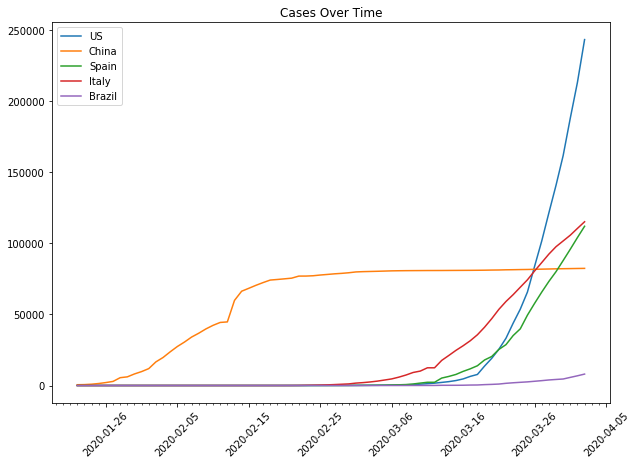

In [7]:
confirmed.columns = pd.to_datetime(confirmed.columns)

plt.figure(figsize = (10,7))
plt.xticks(rotation = 45)
plt.plot(confirmed.columns, confirmed.loc['US'], label = 'US')
plt.plot(confirmed.columns, confirmed.loc['China'], label = 'China')
plt.plot(confirmed.columns, confirmed.loc['Spain'], label = 'Spain')
plt.plot(confirmed.columns, confirmed.loc['Italy'], label = 'Italy')
plt.plot(confirmed.columns, confirmed.loc['Brazil'], label = 'Brazil')
plt.legend()

# Set xaxis tick marks to be regular
years_fmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.title('Cases Over Time')
plt.show()

### Gathering explanatory variables

In this assignment we are trying to investigate causal relationships and correlations between COVID-19 country data and possible population statistics that could affect infection and death rates. So now, we will show you how to load and join possible explanatory variables. 

It has been shown that older individuals are at [higher risk of death due to COVID-19](https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/older-adults.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fspecific-groups%2Fhigh-risk-complications%2Folder-adults.html) so we decided to investigate if the median age of a country is correlated with its death rate as an example.

In [8]:
# Load median age data
median_age = pd.read_csv('median_age.csv')
median_age.drop(['Median Male','Median Female'], axis=1, inplace=True)
median_age.rename(columns={'Median':'median_age', 'Place':'Country/Region'},inplace=True)
median_age.set_index('Country/Region', drop = True, inplace=True)
median_age.head()

,median_age
Country/Region,
Monaco,53.1
Japan,47.3
Germany,47.1
Saint Pierre and Miquelon,46.5
Italy,45.5


We can now calculate the death rate for each country. To do this we decided to use 

$death \; rate = \frac{deaths}{confirmed \; cases}$

because at the time of writing this assignment, the number of resolved cases was very low and likely underreported. If we had better data, a more accurate representation of the death rate would be to use resolved cases in the denominator (where $resolved \; cases = recovered + deaths$)



In [9]:
# Calculate death rate for each country
# Get most recent numbers for recovered and deaths (last column in the data table)
total_confirmed = confirmed[confirmed.columns[-1]]
total_deaths = deaths[deaths.columns[-1]]

death_rate = pd.Series(dtype = float)

# Calculating death rate
if (total_deaths.index == total_confirmed.index).all():
    death_rate = total_deaths/(total_confirmed + total_deaths)
else:
    print('Whoops, looks like your countries dont match')

# Drop countries that have a null death rate (don't have any cases)
death_rate.dropna(inplace=True)

death_rate = pd.DataFrame(death_rate)
death_rate.rename(columns={death_rate.columns[0]:'death_rate'},inplace=True)

A useful tool when working with multiple data tables is the merge function. This function merges two data tables (or columns from data tables) on a column or index of your choosing. One must be careful when merging because you can easily lose or multiply your data because of duplicate or mismatching keys. For this reason, it is important to always check the size of your new data table compared to the old ones. 

You can find more information about the pandas merge function [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) and a more in depth explanation of merges [here](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/).

In [10]:
# Merging death rate and median age 
naive_merge = median_age.merge(death_rate,left_index=True, right_index=True)
naive_merge


,median_age,death_rate
Country/Region,,
Monaco,53.1,0.016393
Japan,47.3,0.024247
Germany,47.1,0.012887
Italy,45.5,0.107737
Slovenia,44.5,0.018600
...,...,...
Malawi,16.5,0.000000
Angola,15.9,0.200000
Uganda,15.8,0.000000


We called our first merge a naive merge because we made the assumption that our two different data sources had all the same countries and named the countries the same. We will check that assumption in the next cell.

In [11]:
# Finding how many countries we lost in our naive merge
print(f'We lost {death_rate.shape[0] - naive_merge.shape[0]} countries in our naive merge')

# Finding the countries we lost
right_merge = median_age.merge(death_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge.median_age.isnull()]

We lost 18 countries in our naive merge


,median_age,death_rate
Country/Region,,
Bahamas,NaN,0.040000
Burma,NaN,0.047619
Cabo Verde,NaN,0.142857
Congo (Brazzaville),NaN,0.083333
Congo (Kinshasa),NaN,0.088435
Cote d'Ivoire,NaN,0.005128
Czechia,NaN,0.011276
Diamond Princess,NaN,0.015214
Eswatini,NaN,0.000000


Of the countries that we lost, we are going to add back the US and South Korea (which is called 'Korea, South' in the data set for some reason). To do this, we simply need to make the names match. 

In [12]:
# To find the corresponding names in the median_age table, we guessed the obvious names 
# and they worked: 'United States' and 'South Korea'

# But if you can't find a name you can try this
# for country in median_age.index:
#     print(country)

# Now we will rename them in the median_age data (so it is consistent with the rest of our data)
median_age.rename(index={'United States':'US','South Korea':'Korea, South'}, inplace=True)

# Redoing our merge
deaths_and_age = median_age.merge(death_rate,left_index=True, right_index=True)

# Make sure it worked, we should have 2 fewer missing countries
print(f'We lost {death_rate.shape[0] - deaths_and_age.shape[0]} countries in our merge')



We lost 16 countries in our merge


### Now that we have workable data let's visualize it.

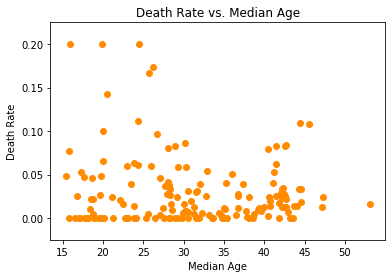

In [13]:
plt.scatter(deaths_and_age.median_age, deaths_and_age.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Median Age')
plt.title('Death Rate vs. Median Age')
plt.show()

### Based on our initial scatter plot a linear relationship doesn't look super promising but let's try it anyway

You can find more information about the package we used for the linear regression [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).

p-values: 0.35339370626947875
R^2: 0.005285847299216592
Slope: -0.00032013215700298314


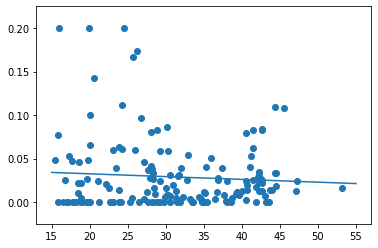

In [14]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(deaths_and_age.median_age, deaths_and_age.death_rate)
predictions = np.linspace(15,55,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(deaths_and_age.median_age, deaths_and_age.death_rate)
plt.plot(np.linspace(15,55,5), predictions)
plt.show()


As we predicted, our linear regression was not successful (as of the writing of this assignment). We encourage you to do your own research on methods of assessing regressions if you don't already have experience in this area and the grutors are happy to talk about it as well. Our regression above is likely an example of 'garbage in, garbage out'. This means that you can't get good information from bad data and coronavirus data is anything but consistent across countries, so you need to be careful about conclusions you draw from your analysis.

Now we have to ask ourselves if we truly believe that age is not a factor in death rate or if our data is misrepresenting reality. Now this is where you come in. You may have noticed that some countries have extremely high death rates that are inconsistent with what we know about the virus. This is likely because the sample size is far too small and furthermore is biased towards critical cases due to a lack of testing. While we can't fix the testing problem, we can try to make the data more reliable by filtering based on sample size. 

Your first task is to filter the data based on a minimum sample size that you deem appropriate (we chose 1000 on March 28th) then re-run the regression and interpret the results. Don't worry if you don't get statistically significant/logical results. 

__Don't forget to save important graphs and statistics for your deliverable.__


## Task 1: Filter on Sample Size and Re-Run Regression


In [15]:
# Get an idea of the numbers of resolved cases for most countries
total_confirmed.describe()

count       181.000000
mean       5597.552486
std       23883.385484
min           1.000000
25%          20.000000
50%         233.000000
75%        1317.000000
max      243453.000000
Name: 2020-04-02 00:00:00, dtype: float64

We lost 1 countries in our naive merge
We lost 0 countries in our merge


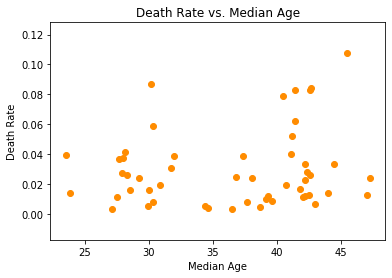

In [16]:
# Calculate death rate for each country
# Get most recent numbers for recovered and deaths (last column in the data table)
death_rate = pd.Series(dtype = float)
# Filter by the sample size of 1000 
filtered_confirmed = total_confirmed[total_confirmed > 1000]
filtered_deaths = total_deaths[total_deaths.index.isin(filtered_confirmed.index)]

death2_rate = pd.Series(dtype = float)

# Calculating death rate
if (filtered_deaths.index == filtered_confirmed.index).all():
    death2_rate = filtered_deaths/(filtered_confirmed + filtered_deaths)
else:
    print('Whoops, looks like your countries dont match')

# Drop countries that have a null death rate (don't have any cases)
death2_rate.dropna(inplace=True)

death2_rate = pd.DataFrame(death2_rate)
death2_rate.rename(columns={death2_rate.columns[0]:'death_rate'},inplace=True)

# Merging death rate and median age 
naive2_merge = median_age.merge(death2_rate,left_index=True, right_index=True)

# Finding how many countries we lost in our naive merge
print(f'We lost {death2_rate.shape[0] - naive2_merge.shape[0]} countries in our naive merge')

# Finding the countries we lost
right_merge = median_age.merge(death2_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge.median_age.isnull()]

# Now we will rename them in the median_age data (so it is consistent with the rest of our data)
median_age.rename(index={'Czech Republic':'Czechia'}, inplace=True)
# Redoing our merge
deaths2_and_age = median_age.merge(death2_rate,left_index=True, right_index=True)

# Make sure it worked, we should have 2 fewer missing countries
print(f'We lost {death2_rate.shape[0] - deaths2_and_age.shape[0]} countries in our merge')

plt.scatter(deaths2_and_age.median_age, deaths2_and_age.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Median Age')
plt.title('Death Rate vs. Median Age')
plt.show()


p-values: 0.2626107312969402
R^2: 0.02503189765307188
Slope: 0.0006084849030462419


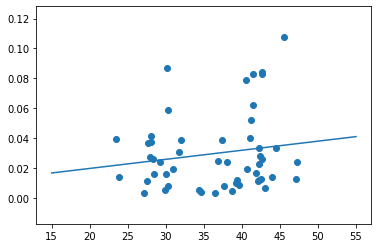

In [17]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(deaths2_and_age.median_age, deaths2_and_age.death_rate)
predictions = np.linspace(15,55,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(deaths2_and_age.median_age, deaths2_and_age.death_rate)
plt.plot(np.linspace(15,55,5), predictions)
plt.show()

Once again, we fail to see a relationship between median age and death rate. Although, the results we find here, although inconclusive, is more in line with the prediction that older people are more affected by it as we see a positive slope which means that death rate increases as median age increases. Unfortunately, our p-value is greater than 0.05 so this result is not statistically significant. 


## Task 2: Find Your Own Data
Now, armed with the code above, you should pose a research question, find and download your own data from the internet, import it and run regressions (at least 2) to investigate your question. For each regression, write what you expect the relationship to be before you run the regression, graph the data, discuss how your results support/refute your initial hypothesis, and what you would need to be more sure of your results. 

You are welcome to continue working at a global scale, but there is also state by state data (and even county level data) in the United States which might yield more interesting results [here](https://covidtracking.com/?fbclid=IwAR3WwZ1nX8qhwJkAi1uYahgpyV94V3xPs0v_RzBBycMPB7p01DMKyDcc9Bk).

There is a wealth of demographic data on the internet that you can couple with the COVID-19 data. You don't need to limit yourself to looking at the death rate, but you can look at any trends with respect to COVID-19 you find interesting.

You can run linear regressions, transform your data (to fit an exponential or quadratic function, for example), run a Multiple Linear Regression, or anything else the questions you want to answer require. Feel free to use all internet resources (as long as you don't copy graphs and results), and the grutors are happy to answer any questions you have.

### Make sure to save graphs and statistics!

Here, I would like to further investigate causal relationships and correlations between the U.S. COVID-19 data and possible population statistics that could affect death rates. I decided to test death rate against median household income. I was wondering if those living in poorer areas had less access to healthcare, food or testing and maybe those in higher income areas could easily afford the healthcare if necessary. So let's explore this relationship. To find this information, I downloaded a dataset from [here](https://worldpopulationreview.com/states/median-household-income-by-state/) which gave the population and median household information of every state in the US. I also downloaded this data which gave the counts of confirmed cases and deaths in each state and county from [here](https://codeload.github.com/nytimes/covid-19-data/zip/master). 

In [34]:
# Let's load in our data for counts per state and county
raw_states = pd.read_csv('us-states.csv')
states = raw_states.drop(['fips'], axis = 1)
raw_counties = pd.read_csv('us-counties.csv')
counties = raw_counties.drop(['fips'], axis = 1)
states = states.groupby('state').sum()

In [35]:
# Load median income per state
data_raw = pd.read_csv('data.csv')
median_income = data_raw.drop(['rank','Population'],axis=1)
median_income.rename(columns={'HouseholdIncome':'median_income', 'State':'state'},inplace=True)
median_income.set_index('state', drop = True, inplace=True)

Now, we want to calculate the death rate at each state and merge the death rate with the median income data frame. We then remove any states lost in the merge, in this case the median income dataset did not include the U.S. territories and so we want to remove them. 

In [40]:
# Calculate death rate for each state
# Get most recent numbers for recovered and deaths (last column in the data table)
total_confirmed = states[states.columns[-2]]
total_deaths = states[states.columns[-1]]
death_rate = pd.Series(dtype = float)

# Calculating death rate
if (total_deaths.index == total_confirmed.index).all():
    death_rate = total_deaths/(total_confirmed + total_deaths)
else:
    print('Whoops, looks like your countries dont match')

death_rate = pd.DataFrame(death_rate)
death_rate.rename(columns={death_rate.columns[0]:'death_rate'},inplace=True)

In [41]:
# Merging death rate and median income 
ID_merge = median_income.merge(death_rate,left_index=True, right_index=True)

# Finding how many states we lost in our naive merge
print(f'We lost {death_rate.shape[0] - ID_merge.shape[0]} states in our naive merge')

# Finding the states we lost
right_merge = median_income.merge(death_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge.median_income.isnull()]

# Redoing our merge
deaths_and_income = median_income.merge(death_rate,left_index=True, right_index=True)


We lost 4 states in our naive merge


Now, we can plot our death rates against median income. It seems that there isn't an obvious relationship between the two variables and when we run a linear regression between the two, it becomes evident that there is no statistically significant relationship between the two variables. I think one reason it failed is because each state has such a large disparity and so I wanted to repeat this with the counties data, however, I could not find a dataset for median household income by county for 2020.

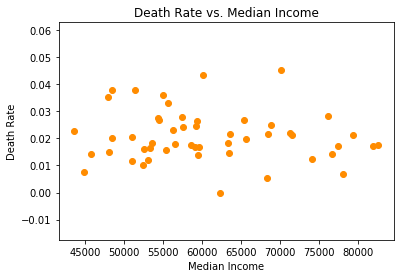

In [42]:
plt.scatter(deaths_and_income.median_income, deaths_and_income.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Median Income')
plt.title('Death Rate vs. Median Income')
plt.show()

p-values: 0.47186587160656357
R^2: 0.010614827554308976
Slope: -9.34566357925243e-08


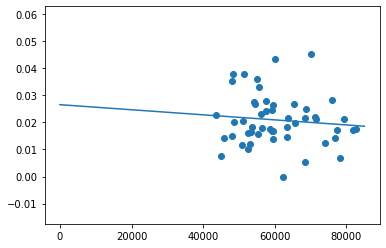

In [43]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(deaths_and_income.median_income, deaths_and_income.death_rate)
predictions = np.linspace(0,85000,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(deaths_and_income.median_income, deaths_and_income.death_rate)
plt.plot(np.linspace(0,85000,5), predictions)
plt.show()

Now let's try finding a relationship between the population size and the death rates. I wanted to see if having a denser and more populated state would have an effect on death rates as a larger population would mean a higher chance of contact, making transmission easier. Having a larger population could also overflow healthcare services in the event of a pandemic. So we repeat the steps we did previously. 

In [44]:
# Load population size per state
population = data_raw.drop(['rank','HouseholdIncome'],axis=1)
population.rename(columns={'HouseholdIncome':'median_income', 'State':'state'},inplace=True)
population.set_index('state', drop = True, inplace=True)

In [45]:
# Merging death rate and median income 
pop_merge = population.merge(death_rate,left_index=True, right_index=True)

# Finding how many states we lost in our naive merge
print(f'We lost {death_rate.shape[0] - pop_merge.shape[0]} states in our naive merge')

# Finding the states we lost
right_merge = population.merge(death_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge.Population.isnull()]

# Redoing our merge
deaths_and_pop = population.merge(death_rate,left_index=True, right_index=True)

We lost 4 states in our naive merge


Once again we see no statistically significant relationship between the two variables. As mentioned previously, I think that a big part of why we don't see a significant relationship may be because the state data is not informative enough and that using county data may give us more information. Ex. new york city is extremely dense and populated but New York also has states like Ithaca with a much smaller and less dense population. Another variable I would try to use in the future would also be population density. Ex. Singapore would have a small population but an extremely large population density considering its land size. 

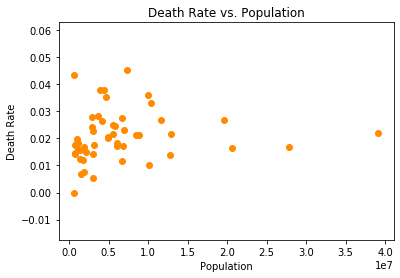

In [46]:
plt.scatter(deaths_and_pop.Population, deaths_and_pop.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Population')
plt.title('Death Rate vs. Population')
plt.show()

p-values: 0.4392361108775047
R^2: 0.012259064078825455
Slope: 1.430054558205904e-10


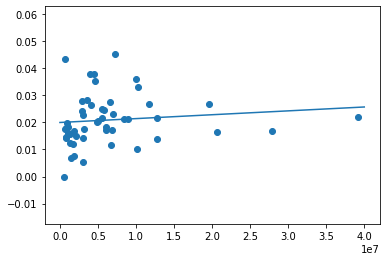

In [47]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(deaths_and_pop.Population, deaths_and_pop.death_rate)
predictions = np.linspace(0.0,4e7,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(deaths_and_pop.Population, deaths_and_pop.death_rate)
plt.plot(np.linspace(0.0,4e7,5), predictions)
plt.show()

## Task 3:
#### A few sentences describing why you decided to take this course/what you were hoping to get from it.
I was hoping to learn a bit about data analysis. I've taken stats classes before so I feel that I have learned a some basic statistical concepts but I don't feel that I've done enough data wrangling and applications of these concepts. I'm also interested in healthcare and this pandemic situation we are in so I think this is a good opportunity for me to pursue my interests while applying what I've learnd in the past. 

#### How long it took you to complete this assignment
It took me around 4 hours because this is my first time using Jupyter notebook and pandas so reading documentation took a bit of time. Although most of my time was trying to find a dataset I could use for my research question. Originally I wanted to explore the relationship between weather and deaths but I could not get good weather data and once I got it, I didn't know how to make it usable so I had to give up on it as it was taking too much time. 